In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data=pd.read_csv('analysis_rfm_1010nooutlier.csv')

In [3]:
del data['Unnamed: 0']
data=data.set_index('userid')
data.head()

,restart_number,map_name,difficulty,win_loss_quit,round_reached,lives_left,player_rank,current_shards,current_gold,current_gems,...,initial_nappopen,initial_ngames,initial_ndays,n_games,wlqgtr_cnt,active_days,platform,iphoneplayer,android,steam
userid,,,,,,,,,,,,,,,,,,,,,
NO_LINK02F380F1-7E3F-45E7-B017-5A4FE37EE339,0,map_Cyclops_Tears,Hard,Win,60,100,41,194,913,123,...,19,52,12,178,18,180,Android,0.0,1.0,0.0
NO_LINK038c0194ca0f1e0dbd0e48860dfd02e4,0,map_WinterIsComing_SnowPlains,Easy,Win,30,175,2,20,760,9,...,18,37,9,44,11,184,Android,0.0,1.0,0.0
NO_LINK03de89217dd2c340f47ee91ac083b1d2,0,map_Enchiridion_HotdogPrincessKingdom,Medium,Win,45,150,9,126,116,58,...,11,23,9,26,13,16,Android,0.0,1.0,0.0
NO_LINK066c43914fe0419e38f34042ef0ed7e9,0,map_PirateInPeril_UnderwaterChasm,Easy,Win,30,200,4,95,1652,35,...,1,2,1,12,3,122,Android,0.0,1.0,0.0
NO_LINK1ccb9958acfa54eb1b1024473fd9d593a7b5fc6b,0,map_WinterIsComing_SnowPlains,Medium,Quit,0,150,10,170,81,42,...,3,14,2,36,6,99,Android,0.0,1.0,0.0


In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['platform']= le.fit_transform(data['platform'])
data['win_loss_quit'] = le.fit_transform(data['win_loss_quit'])
data['difficulty'] = le.fit_transform(data['difficulty'])
data['map_name'] = le.fit_transform(data['map_name'])
data['active_status'] = le.fit_transform(data['active_status'])

In [5]:
feature_cols = ['map_name','difficulty','win_loss_quit','round_reached','lives_left','player_rank','current_shards','current_gold','current_gems','countofdays','frequency_in_total','app_opened_perday_median','avg_duration_mins','difficulty_skull','easy_count','medium_count','hard_count','impoppable_count','active_weeks','initial_2_weeks','initial_nappopen','initial_ngames','initial_ndays','n_games','wlqgtr_cnt','platform','iphoneplayer','steam','android']

In [6]:
x=data[feature_cols]
y=data.active_status

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.30)


In [8]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=10)
# Train Decision Tree Classifer
dtc = dtc.fit(x_train,y_train)
#Predict the response for test dataset
y_pred = dtc.predict(x_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#create a new random forest classifier
rf =  RandomForestClassifier(n_estimators=100,  
random_state=0,  
max_features = 'sqrt',  
n_jobs=-1, verbose = 1)
#fit model to training data
rf.fit(x_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [10]:
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
log_reg = LogisticRegression()
#fit the model to the training data
log_reg.fit(x_train, y_train)

/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)

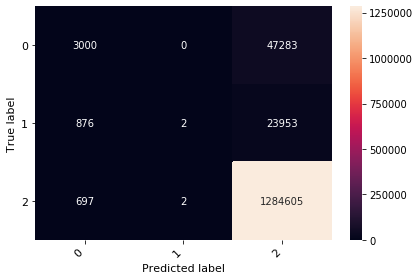

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

In [27]:
from sklearn.linear_model import SGDClassifier
SGD = SGDClassifier(alpha=0.001, loss='modified_huber', max_iter=100, tol=1e-3).fit(x_train, y_train)

In [28]:
print('dtc: {}'.format(dtc.score(x_test, y_test)))
print('rf: {}'.format(rf.score(x_test, y_test)))
print('log_reg: {}'.format(log_reg.score(x_test, y_test)))
print('abc: {}'.format(abc.score(x_test, y_test)))
print('SGD: {}'.format(SGD.score(x_test, y_test)))


dtc: 0.9469229310403126


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    9.7s finished


rf: 0.9450896709687757
log_reg: 0.945077174809507
abc: 0.9464789498521777
SGD: 0.944339901412654


In [29]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('dtc', dtc), ('rf', rf), ('log_reg', log_reg), ('abc', abc),('SGD', SGD)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')
#fit model to training data
ensemble.fit(x_train, y_train)
#test our model on the test data
ensemble.score(x_test, y_test)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test, ensemble.predict(x_test))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

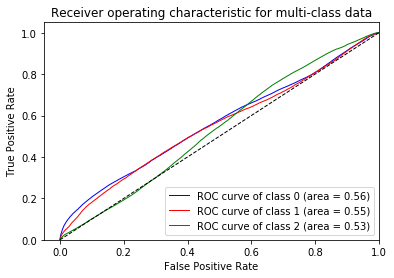

In [52]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [37]:
y_pred=clf.predict(x_test)

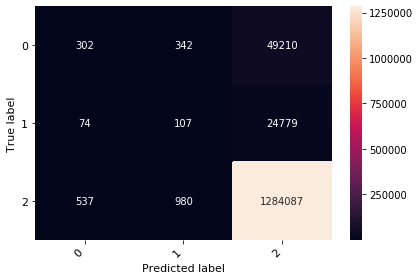

In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix= confusion_matrix(y_test, clf.predict(x_test))
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 10}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 11)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 11)
plt.ylabel('True label', fontsize = 11)
plt.xlabel('Predicted label', fontsize = 11)
plt.tight_layout()

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print(accuracy_score(y_test,y_pred ))
print(precision_score(y_test, y_pred,pos_label='positive',average='weighted'))
print(recall_score(y_test, y_pred,pos_label='positive',average='weighted'))
print(f1_score(y_test, y_pred,pos_label='positive',average='weighted'))


0.9441921527060065


/home/nkadmin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1259: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


0.9070174472467649
0.9441921527060065
0.9186011090826058


In [20]:
from sklearn import svm
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')

In [ ]:
clf.fit(x_train, y_train)